## Plan

This jupyter notebook breaks down the flow of using OCHRE for HVAC 
supervisory control.

In [217]:
#function needed:
import pandas as pd

def attach_epw_to_df(df, epw_path,
                     keep_cols=("Dry Bulb (C)",
                                "Relative Humidity (%)",
                                "Global Horizontal Radiation (Wh/m^2)",
                                "Wind Speed (m/s)"),
                     out_names=("Temperature - Outdoor (C) [EPW]",
                                "Relative Humidity - Outdoor (%) [EPW]",
                                "Global Horizontal Irradiance (W/m^2) [EPW]",  # EPW is Wh/m² (hourly avg)
                                "Wind Speed - Outdoor (m/s) [EPW]")):
    # --- read EPW ---
    cols = [
        "Year","Month","Day","Hour","Minute","Flags",
        "Dry Bulb (C)","Dew Point (C)","Relative Humidity (%)","Atmos Pressure (Pa)",
        "Extraterrestrial Horizontal Radiation (Wh/m^2)",
        "Extraterrestrial Direct Normal Radiation (Wh/m^2)",
        "Horizontal IR Intensity (Wh/m^2)",
        "Global Horizontal Radiation (Wh/m^2)",
        "Direct Normal Radiation (Wh/m^2)",
        "Diffuse Horizontal Radiation (Wh/m^2)",
        "Global Horizontal Illuminance (lux)",
        "Direct Normal Illuminance (lux)",
        "Diffuse Horizontal Illuminance (lux)",
        "Zenith Luminance (Cd/m^2)",
        "Wind Direction (deg)","Wind Speed (m/s)","Total Sky Cover (tenths)",
        "Opaque Sky Cover (tenths)","Visibility (km)","Ceiling Height (m)",
        "Present Weather Observation","Present Weather Codes",
        "Precipitable Water (mm)","Aerosol Optical Depth (thousandths)",
        "Snow Depth (cm)","Days Since Last Snowfall",
        "Albedo","Liquid Precipitation Depth (mm)","Liquid Precipitation Quantity (hr)"
    ]
    epw = pd.read_csv(epw_path, skiprows=8, header=None, names=cols)

    # --- Build timestamp ignoring EPW 'Year' ---
    # EPW Hour = 1..24 marks END of hour → convert to start of hour
    h = epw["Hour"].to_numpy()
    carry = (h == 24).astype(int)
    hour0 = (h % 24)

    # choose a single year: the sim's year
    sim_year = int(df.index[0].year)

    dt = pd.to_datetime({
        "year": sim_year,                            # force a single year
        "month": epw["Month"],
        "day": epw["Day"],
        "hour": hour0,
        # EPW minute is usually 0 for hourly TMY; include if present
        "minute": epw["Minute"] if "Minute" in epw else 0
    })
    # shift hour=24 rows to next day (now within the same sim_year)
    dt = dt + pd.to_timedelta(carry, unit="D")

    wx = epw.set_index(dt)[list(keep_cols)].copy()
    wx.columns = list(out_names)

    # RH sanity
    if "Relative Humidity - Outdoor (%) [EPW]" in wx:
        wx["Relative Humidity - Outdoor (%) [EPW]"] = wx["Relative Humidity - Outdoor (%) [EPW]"].clip(0, 100)

    # Align to sim timeline; hourly → sub-hourly via forward-fill
    # If df has irregular start (e.g., not exactly at :00), also bfill edges.
    wx_aligned = wx.reindex(df.index, method="ffill").bfill()

    # Join
    out = df.join(wx_aligned, how="left")
    return out




## Step 1
Initialize the building and weather data. Note, how scheduling is also 
initialized, but this is for other power loads in the house (washer, dryer, 
etc.) 

In [218]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ochre import CreateFigures
from ochre import Dwelling
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
default_input_path = os.path.join(PROJECT_ROOT, "ochre", "defaults")

timestep_sim = 1 # timestep of simulation in minutes

dwelling_args = {
    # Timing parameters
    "start_time": dt.datetime(2018, 1, 1, 0, 0),  # (year, month, day, hour, 
    # minute)
    "time_res": dt.timedelta(minutes=timestep_sim),         # time resolution
    # of the simulation
    "duration": dt.timedelta(days=1),             # duration of the 
    # simulation to just initialize. Will change later
    "verbosity": 6,

    # Input files
    "hpxml_file": os.path.join(default_input_path, "Input Files", "bldg0112631-up11.xml"),
    "hpxml_schedule_file": os.path.join(default_input_path, "Input Files", "bldg0112631_schedule.csv"),
    "weather_file": os.path.join(default_input_path, "Weather", "USA_CO_Denver.Intl.AP.725650_TMY3.epw"),
}

# Create Dwelling model
dwelling = Dwelling(**dwelling_args)
heater = dwelling.get_equipment_by_end_use("HVAC Heating")
schedule = heater.schedule
schedule["HVAC Heating Deadband (C)"] = 2
peak_times = (schedule.index.hour >= 10) & (schedule.index.hour < 15)
schedule.loc[peak_times, "HVAC Heating Setpoint (C)"] -= 3

heater.min_on_time = 600*2          # min cycle on for 
heater.min_off_time = 600*2         # min cycle off for

heater.reset_time()

df, metrics, hourly = dwelling.simulate()

2025-10-20 16:54:35.293115 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-10-20 16:54:35.294278 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre.csv
2025-10-20 16:54:35.309237 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_metrics.csv
2025-10-20 16:54:35.309390 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_hourly.csv
2025-10-20 16:54:35.309493 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-20 16:54:35.557553 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-10-20 16:54:35.562385 - ochre at 2018-01-01 00:00:00: Running Simulation for 1 day, 0:00:00
2025-10-20 16:

In [219]:
dwelling

In [220]:
df.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),Lighting Electric Power (kW),HVAC Cooling Electric Power (kW),Other Electric Power (kW),Water Heating Electric Power (kW),...,Temperature - Ground (C),Net Sensible Heat Gain - Indoor (W),Net Sensible Heat Gain - Foundation (W),Net Sensible Heat Gain - Garage (W),Net Sensible Heat Gain - Attic (W),Infiltration Heat Gain - Indoor (W),Forced Ventilation Heat Gain - Indoor (W),Natural Ventilation Heat Gain - Indoor (W),Internal Heat Gain - Indoor (W),Window Transmitted Solar Gain (W)
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,6.529479,-3234.197179,-3157.025931,-7240.811301,-310.210724,-3578.392666,-0.0,-0.0,365.640333,0.0
2018-01-01 00:01:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,6.529479,-3210.218689,-3079.732433,-7055.657737,-292.755506,-3560.331869,-0.0,-0.0,365.640333,0.0
2018-01-01 00:02:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,6.529479,-3187.425448,-3012.066928,-6887.029134,-290.824793,-3542.804981,-0.0,-0.0,365.640333,0.0
2018-01-01 00:03:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,6.529479,-3165.139969,-2948.488956,-6724.990990,-287.534525,-3525.788390,-0.0,-0.0,365.640333,0.0
2018-01-01 00:04:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,6.529479,-3143.599224,-2888.973822,-6569.929335,-284.277552,-3509.259999,-0.0,-0.0,365.640333,0.0


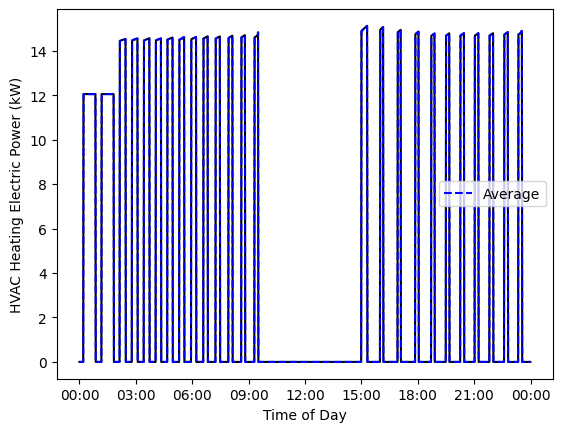

In [221]:
fig = CreateFigures.plot_daily_profile(df, 'HVAC Heating Electric Power (kW)', 
                                       plot_max=False, plot_min=False)

<Axes: xlabel='Time'>

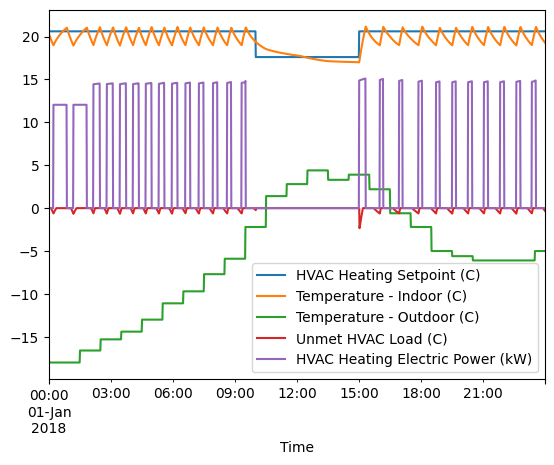

In [222]:
cols_to_plot = [
    "HVAC Heating Setpoint (C)",
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Unmet HVAC Load (C)",
    "HVAC Heating Electric Power (kW)",
]
df.loc[:, cols_to_plot].plot()

## Create training dataset
This portion will segment data to be trained on. This represents the "real" 
homes data. 

Input the number of training days you want.

In [223]:
train_days = 30

dwelling_args.update({
    "start_time": dt.datetime(2018, 1, 1, 0, 0),
    "duration": dt.timedelta(days=30),
    "verbosity": 9
    }
)
dwelling_train = Dwelling(**dwelling_args)
df_train, metrics_train, hourly_train = dwelling_train.simulate()

2025-10-20 16:54:36.472445 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-10-20 16:54:36.472916 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre.csv
2025-10-20 16:54:36.476018 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_metrics.csv
2025-10-20 16:54:36.476130 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_hourly.csv
2025-10-20 16:54:39.236204 - ochre at 2018-01-01 00:00:00: Saved schedule to: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-20 16:54:39.657425 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-10-20 16:54:39.756094 - ochre at 2018-01-01 00:00:00: Running Simulation for 30 days, 0:00:00
2025-10-20 16:54:59.99317

In [224]:
df_train_with_weather = attach_epw_to_df(df_train, 
                                         dwelling_args["weather_file"])

In [225]:
df_train.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),Lighting Electric Power (kW),HVAC Cooling Electric Power (kW),Other Electric Power (kW),Water Heating Electric Power (kW),...,Garage Furniture Garage Film Coefficient (m^2-K/W),Attic Wall Attic LWR Gain (W),Attic Wall Attic Surface Temperature (C),Attic Wall Attic Film Coefficient (m^2-K/W),Attic Roof Attic LWR Gain (W),Attic Roof Attic Surface Temperature (C),Attic Roof Attic Film Coefficient (m^2-K/W),Attic Floor Attic LWR Gain (W),Attic Floor Attic Surface Temperature (C),Attic Floor Attic Film Coefficient (m^2-K/W)
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,0.325486,22.309686,-16.256040,0.325486,206.911467,-16.386411,0.536264,-229.221153,-15.255291,0.561134
2018-01-01 00:01:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,0.325486,20.571307,-16.233508,0.325486,189.203949,-16.349772,0.536264,-209.775257,-15.314849,0.561134
2018-01-01 00:02:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,0.325486,20.527204,-16.235591,0.325486,189.397536,-16.353086,0.536264,-209.924739,-15.317247,0.561134
2018-01-01 00:03:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,0.325486,20.439605,-16.239104,0.325486,187.824788,-16.354216,0.536264,-208.264393,-15.326690,0.561134
2018-01-01 00:04:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,0.325486,20.227603,-16.247370,0.325486,186.303508,-16.362352,0.536264,-206.531110,-15.343128,0.561134


In [226]:
df_train_with_weather.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),Lighting Electric Power (kW),HVAC Cooling Electric Power (kW),Other Electric Power (kW),Water Heating Electric Power (kW),...,Attic Roof Attic LWR Gain (W),Attic Roof Attic Surface Temperature (C),Attic Roof Attic Film Coefficient (m^2-K/W),Attic Floor Attic LWR Gain (W),Attic Floor Attic Surface Temperature (C),Attic Floor Attic Film Coefficient (m^2-K/W),Temperature - Outdoor (C) [EPW],Relative Humidity - Outdoor (%) [EPW],Global Horizontal Irradiance (W/m^2) [EPW],Wind Speed - Outdoor (m/s) [EPW]
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,206.911467,-16.386411,0.536264,-229.221153,-15.255291,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:01:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,189.203949,-16.349772,0.536264,-209.775257,-15.314849,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:02:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,189.397536,-16.353086,0.536264,-209.924739,-15.317247,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:03:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,187.824788,-16.354216,0.536264,-208.264393,-15.326690,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:04:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.016273,0.05,0.230687,0.001,...,186.303508,-16.362352,0.536264,-206.531110,-15.343128,0.561134,-18.0,85.0,0.0,0.0


Isolate the training data-set needed for envelope training.

In [227]:
df_envelope_train = df_train_with_weather[["HVAC Heating Electric Power (kW)", 
                              "HVAC Heating ER Power (kW)", 
                              "HVAC Heating Fan Power (kW)",
                              "HVAC Heating Delivered (W)",
                              "HVAC Heating Setpoint (C)",
                              "HVAC Cooling Setpoint (C)",
                              "HVAC Cooling Electric Power (kW)",
                              "HVAC Cooling Delivered (W)",
                              "Temperature - Indoor (C)", 
                              "Relative Humidity - Indoor (-)", 
                              "Temperature - Outdoor (C)",
                              "Temperature - Outdoor (C) [EPW]", 
                              "Global Horizontal Irradiance (W/m^2) [EPW]",
                              "Relative Humidity - Outdoor (%) [EPW]",
                              "Wind Speed - Outdoor (m/s) [EPW]"]]


In [228]:
df_envelope_train_1min = df_envelope_train
df_envelope_train.head()
#df_envelope_train["Temperature - Outdoor (C) [EPW]"].plot()

,HVAC Heating Electric Power (kW),HVAC Heating ER Power (kW),HVAC Heating Fan Power (kW),HVAC Heating Delivered (W),HVAC Heating Setpoint (C),HVAC Cooling Setpoint (C),HVAC Cooling Electric Power (kW),HVAC Cooling Delivered (W),Temperature - Indoor (C),Relative Humidity - Indoor (-),Temperature - Outdoor (C),Temperature - Outdoor (C) [EPW],Global Horizontal Irradiance (W/m^2) [EPW],Relative Humidity - Outdoor (%) [EPW],Wind Speed - Outdoor (m/s) [EPW]
Time,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,20.293399,0.045400,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:01:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,20.176147,0.044934,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:02:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,20.062137,0.045278,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:03:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,19.951233,0.045616,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:04:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,19.843309,0.045949,-18.0,-18.0,0.0,85.0,0.0


## Training dataset is ready to use
Training dataset is prepared. You can further exclude other variables to 
better represent the available measurements in a home. For example, it is 
unlikely to get the total heat delivered and total cooling delivered. You 
will likely only have power measurements, or indicators that the unit is on 
or off.

In the training dataset, there is:
HVAC power (including resistance heat) (kW), HVAC Heating ER Power (kW), HVAC 
Fan power (kW), HVAC Heating delivered (W), Indoor zone temperature (C), Indoor 
relative humidity (-),  Outdoor temperature (C), Outdoor relative humidity (-), 
Global horizontal irradiance (W/m^2), and Outdoor wind speed (m/s)

dataframe: df_envelope_train

Choose what time-step you would like for training

In [229]:
timestep_train = 60 #minutes
dt_train = timestep_train/60 #convert to hours
df_envelope_train = df_envelope_train.resample(f'{timestep_train}min').mean()

In [230]:
df_envelope_train.head()
#df_envelope_train["Temperature - Indoor (C)"].plot()

,HVAC Heating Electric Power (kW),HVAC Heating ER Power (kW),HVAC Heating Fan Power (kW),HVAC Heating Delivered (W),HVAC Heating Setpoint (C),HVAC Cooling Setpoint (C),HVAC Cooling Electric Power (kW),HVAC Cooling Delivered (W),Temperature - Indoor (C),Relative Humidity - Indoor (-),Temperature - Outdoor (C),Temperature - Outdoor (C) [EPW],Global Horizontal Irradiance (W/m^2) [EPW],Relative Humidity - Outdoor (%) [EPW],Wind Speed - Outdoor (m/s) [EPW]
Time,,,,,,,,,,,,,,,
2018-01-01 00:00:00,6.224390,6.047263,0.177126,4830.728977,20.611111,21.611111,0.05,0.0,19.581110,0.047393,-18.00,-18.0,0.0,85.0,0.0
2018-01-01 01:00:00,6.349753,4.876825,0.262832,5480.492444,20.611111,21.611111,0.05,0.0,19.496098,0.049133,-17.30,-18.0,0.0,85.0,0.0
2018-01-01 02:00:00,6.285900,3.511314,0.342825,6031.767116,20.611111,21.611111,0.05,0.0,19.522279,0.050711,-15.95,-16.6,0.0,83.0,0.0
2018-01-01 03:00:00,6.297481,3.511314,0.342825,6123.561187,20.611111,21.611111,0.05,0.0,19.466874,0.052841,-14.85,-15.3,0.0,85.0,0.0
2018-01-01 04:00:00,4.369459,1.560584,0.342825,4714.784377,20.611111,21.611111,0.05,0.0,19.482121,0.055199,-13.70,-14.4,0.0,90.0,0.0


## Implement Training algorithm below

RC training used as an example

In [231]:
df_heating_annual_night = df_envelope_train.copy()
df_heating_annual_night['Hour'] = df_envelope_train.index.hour

# Define night and day conditions
# Condition 1: Time is between 10 PM and 6 AM
night_time_condition = (df_heating_annual_night['Hour'] >= 20) | \
                       (df_heating_annual_night['Hour'] < 6)

# Condition 2: Solar Irradiation is 0 (assuming 'SolarRadiation' is the correct column name)
if 'Global Horizontal Irradiance (W/m^2) [EPW]' in df_heating_annual_night.columns:
    night_solar_condition = (df_heating_annual_night['Global Horizontal Irradiance (W/m^2) [EPW]'] == 0)
    df_heating_annual_night['is_night'] = night_time_condition & night_solar_condition
else:
    print("\nWarning: 'Global Horizontal Irradiance (W/m^2) [EPW]' column not found after preprocessing. Cannot use it for night/day split.")
    df_heating_annual_night['is_night'] = night_time_condition # Fallback to just time condition

df_heating_annual_night['is_night']

Time
2018-01-01 00:00:00     True
2018-01-01 01:00:00     True
2018-01-01 02:00:00     True
2018-01-01 03:00:00     True
2018-01-01 04:00:00     True
                       ...  
2018-01-30 19:00:00    False
2018-01-30 20:00:00     True
2018-01-30 21:00:00     True
2018-01-30 22:00:00     True
2018-01-30 23:00:00     True
Freq: 60min, Name: is_night, Length: 720, dtype: bool

In [232]:
boolean_night = df_heating_annual_night['is_night'].astype(int)
boolean_night

Time
2018-01-01 00:00:00    1
2018-01-01 01:00:00    1
2018-01-01 02:00:00    1
2018-01-01 03:00:00    1
2018-01-01 04:00:00    1
                      ..
2018-01-30 19:00:00    0
2018-01-30 20:00:00    1
2018-01-30 21:00:00    1
2018-01-30 22:00:00    1
2018-01-30 23:00:00    1
Freq: 60min, Name: is_night, Length: 720, dtype: int64

In [233]:
T_in = df_envelope_train["Temperature - Indoor (C)"].to_numpy()
Y = np.diff(T_in) / float(dt_train)  

X1 = df_envelope_train["HVAC Heating Delivered (W)"].to_numpy()[:-1] / 1000.0
X2 = (df_envelope_train["Temperature - Outdoor (C)"].to_numpy()
      - df_envelope_train["Temperature - Indoor (C)"].to_numpy())[:-1]
X3 = df_envelope_train["Global Horizontal Irradiance (W/m^2) [EPW]"].to_numpy()[:-1] / 1000.0
X4 = boolean_night.to_numpy()[:-1].astype(float)
X = np.column_stack((X1, X2, X3, X4))

In [234]:
theta, residuals, rank, s = np.linalg.lstsq(X,Y)

/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_34924/1768169635.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta, residuals, rank, s = np.linalg.lstsq(X,Y)


In [235]:
theta

array([0.03626265, 0.00541014, 0.18404181, 0.00701326])

In [236]:
C = 1/theta[0]
R = 1/(theta[1]*C)
eta_s = C*theta[2]
w = C*theta[3]

print(f"Resistance is: {R:.4g} C/kW \n")
print(f"Capacitance is: {C:.4g} kWh/C \n")
print(f"Night disturbance is: {w:.4g} kW \n")
print(f"Solar gain efficiency to indoor conditions is: {eta_s:.4g} kW per "
      f"(kW/m²)\n \n")


Resistance is: 6.703 C/kW 

Capacitance is: 27.58 kWh/C 

Night disturbance is: 0.1934 kW 

Solar gain efficiency to indoor conditions is: 5.075 kW per (kW/m²)
 



## Validation data-set for model validation

In [237]:
validate_days = 30

dwelling_args.update({
    "start_time": dt.datetime(2018, 2, 1, 0, 0),
    "duration": dt.timedelta(days=30),
    "verbosity": 9
    }
)
dwelling_validate = Dwelling(**dwelling_args)
df_validate, metrics_validate, hourly_validate = dwelling_validate.simulate()
df_validate_with_weather = attach_epw_to_df(df_validate, 
                                         dwelling_args["weather_file"])



2025-10-20 16:55:00.979281 - ochre at 2018-02-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-10-20 16:55:00.979661 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre.csv
2025-10-20 16:55:00.985374 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_metrics.csv
2025-10-20 16:55:00.985503 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_hourly.csv
2025-10-20 16:55:00.985621 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-20 16:55:03.909730 - ochre at 2018-02-01 00:00:00: Saved schedule to: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-20 16:55:04.34

In [242]:
df_envelope_validate = df_validate_with_weather[[
                              "HVAC Heating Electric Power (kW)", 
                              "HVAC Heating ER Power (kW)", 
                              "HVAC Heating Fan Power (kW)",
                              "HVAC Heating Delivered (W)",
                              "HVAC Heating Setpoint (C)",
                              "HVAC Cooling Setpoint (C)",
                              "HVAC Cooling Electric Power (kW)",
                              "HVAC Cooling Delivered (W)",
                              "Temperature - Indoor (C)", 
                              "Relative Humidity - Indoor (-)", 
                              "Temperature - Outdoor (C)",
                              "Temperature - Outdoor (C) [EPW]", 
                              "Global Horizontal Irradiance (W/m^2) [EPW]",
                              "Relative Humidity - Outdoor (%) [EPW]",
                              "Wind Speed - Outdoor (m/s) [EPW]"]]

df_envelope_validate = (df_envelope_validate.resample(f'{timestep_train}min')
                        .mean())

In [243]:
def add_is_night_column(df, ghi_col="Global Horizontal Irradiance (W/m^2) [EPW]"):
    if "Hour" not in df.columns:
        df["Hour"] = df.index.hour
    night_time_condition = (df["Hour"] >= 20) | (df["Hour"] < 6)
    if ghi_col in df.columns:
        night_solar_condition = (df[ghi_col] == 0)
        df["is_night"] = (night_time_condition & night_solar_condition).astype(float)
    else:
        # Fallback to time-only if EPW GHI is missing (keeps consistency with training fallback)
        df["is_night"] = night_time_condition.astype(float)

def simulate_Tin_forward_euler(df, theta,
                               Tin_col="Temperature - Indoor (C)",
                               Tout_col="Temperature - Outdoor (C)",
                               Qdeliv_W_col="HVAC Heating Delivered (W)",
                               ghi_col="Global Horizontal Irradiance (W/m^2) [EPW]",
                               night_col="is_night"):
    
    Tin = df[Tin_col].to_numpy(dtype=float)
    Tout = df[Tout_col].to_numpy(dtype=float)
    QkW = df[Qdeliv_W_col].to_numpy(dtype=float) / 1000.0
    GHI_kWm2 = df[ghi_col].to_numpy(dtype=float) / 1000.0
    night = df[night_col].to_numpy(dtype=float)

    dt = dt_train

    Tin_hat = np.empty_like(Tin)
    Tin_hat[0] = Tin[0]
    t0, t1, t2, t3 = theta

    for k in range(len(Tin) - 1):
        dTin_dt = t0 * QkW[k] + t1 * (Tout[k] - Tin_hat[k]) + t2 * GHI_kWm2[k] + t3 * night[k]
        Tin_hat[k + 1] = Tin_hat[k] + dt * dTin_dt

    return Tin_hat

def rmse(y_true, y_pred):
    return float(np.sqrt(np.nanmean((y_true - y_pred) ** 2)))

def r2(y_true, y_pred):
    ss_res = float(np.nansum((y_true - y_pred) ** 2))
    ss_tot = float(np.nansum((y_true - np.nanmean(y_true)) ** 2))
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

TRAIN     RMSE: 0.550 °C   R²: -2.358
VALIDATION RMSE: 0.738 °C   R²: -6.012


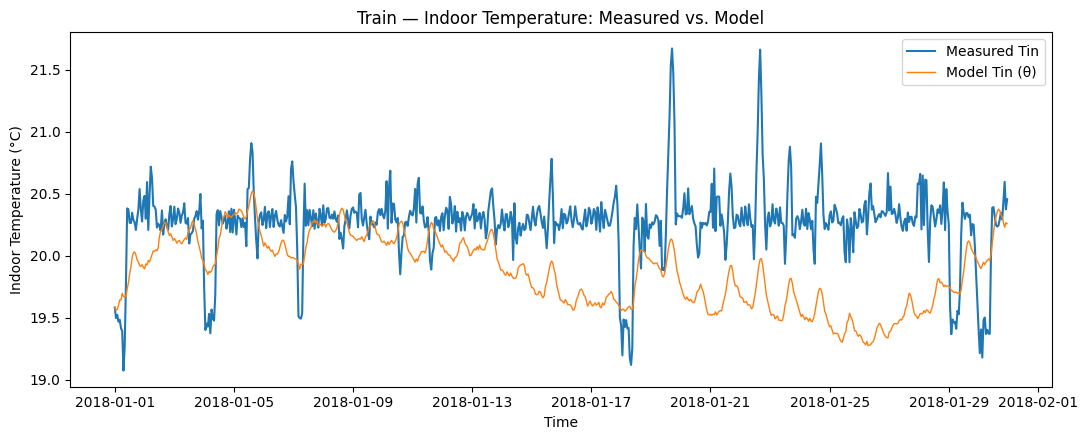

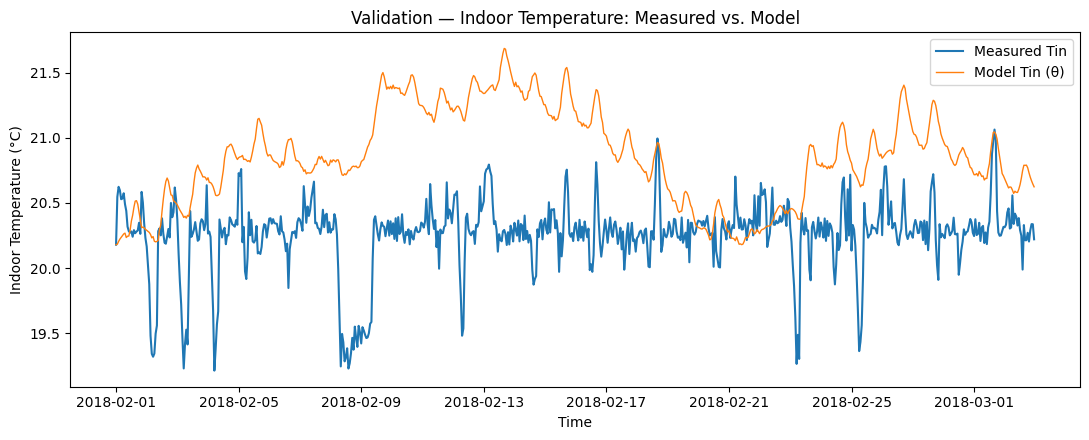

In [245]:
# --- build night flags to mirror training ----------------------------------
add_is_night_column(df_envelope_train)
add_is_night_column(df_envelope_validate)

# --- simulate on train ------------------------------------------------------
Tin_train = df_envelope_train["Temperature - Indoor (C)"].to_numpy(dtype=float)
Tin_hat_train = simulate_Tin_forward_euler(
    df_envelope_train,
    theta=theta,
    Tin_col="Temperature - Indoor (C)",
    Tout_col="Temperature - Outdoor (C)",
    Qdeliv_W_col="HVAC Heating Delivered (W)",
    ghi_col="Global Horizontal Irradiance (W/m^2) [EPW]",
    night_col="is_night"
)
rmse_train = rmse(Tin_train, Tin_hat_train)
r2_train = r2(Tin_train, Tin_hat_train)

# --- simulate on validation -------------------------------------------------
Tin_val = df_envelope_validate["Temperature - Indoor (C)"].to_numpy(dtype=float)
Tin_hat_val = simulate_Tin_forward_euler(
    df_envelope_validate,
    theta=theta,
    Tin_col="Temperature - Indoor (C)",
    Tout_col="Temperature - Outdoor (C)",
    Qdeliv_W_col="HVAC Heating Delivered (W)",
    ghi_col="Global Horizontal Irradiance (W/m^2) [EPW]",
    night_col="is_night"
)
rmse_val = rmse(Tin_val, Tin_hat_val)
r2_val = r2(Tin_val, Tin_hat_val)

# --- report -----------------------------------------------------------------
print(f"TRAIN     RMSE: {rmse_train:.3f} °C   R²: {r2_train:.3f}")
print(f"VALIDATION RMSE: {rmse_val:.3f} °C   R²: {r2_val:.3f}")

# --- figure: train indoor temperature ---------------------------------
plt.figure(figsize=(11, 4.5))
plt.plot(df_envelope_train.index, Tin_train, label="Measured Tin")
plt.plot(df_envelope_train.index, Tin_hat_train, label="Model Tin (θ)", 
         linewidth=1)
plt.xlabel("Time")
plt.ylabel("Indoor Temperature (°C)")
plt.title("Train — Indoor Temperature: Measured vs. Model")
plt.legend()
plt.tight_layout()
plt.show()


# --- figure: validation indoor temperature ---------------------------------
plt.figure(figsize=(11, 4.5))
plt.plot(df_envelope_validate.index, Tin_val, label="Measured Tin")
plt.plot(df_envelope_validate.index, Tin_hat_val, label="Model Tin (θ)", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Indoor Temperature (°C)")
plt.title("Validation — Indoor Temperature: Measured vs. Model")
plt.legend()
plt.tight_layout()
plt.show()